# Inpainting Project

#### Imports

In [213]:
#-*- coding: utf-8 -*-
%matplotlib inline

import importlib
import utils
import appendix_figures

import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
import numpy as np

import random

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (confusion_matrix,
                             accuracy_score)
from sklearn.grid_search import GridSearchCV
from sklearn.manifold import Isomap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import (LinearRegression, 
                                  RidgeClassifierCV, 
                                  LassoCV, Lasso)
from tqdm import trange

importlib.reload(utils)
importlib.reload(appendix_figures)
from utils import *
from appendix_figures import *

In [214]:
train_file = "USPS/USPS_train.txt"
test_file = "USPS/USPS_test.txt"

## Préambule : régression linéaire, régression ridge et LASSO

### Fonctions de base pour manipuler les données USPS

In [215]:
def load_usps(fn):
    """ Lire un fichier USPS """

    with open(fn, "r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split()) > 2]
    tmp = np.array(data)

    # Retourne la seconde colonne jusqu'à la dernière tmp[:,1:], ainsi que
    # la première colonne tmp[:,0]
    return tmp[:, 1:], tmp[:, 0].astype(int)


def extract_one_number(number, datax, datay):
    
    indexes = np.hstack(np.where(datay == number)[0])
    return datax[indexes]


def extract_usps(fichier, firstclass, secondclass):
    """ Permet de construire un ensemble de données datax, datay avec les
        données USPS, juste en lui spécifiant en paramètre:
        :param fichier: le fichier,
        :param firstclass: le premier chiffre dont on veut extraire les données
        :param secondclass: le second chiffre.
        :return: datax, datay
    """

    pixels, numbers = load_usps(fichier)
    indexes69 = np.hstack(
        np.where(
            numbers == i)[0] for i in (
            firstclass,
            secondclass))
    pixels69 = pixels[indexes69]
    numbers69 = numbers[indexes69]
    pixels69y = np.ones(pixels69.shape[0])

    for i in range(numbers69.shape[0]):
        if numbers69[i] == firstclass:
            pixels69y[i] = -1
        else:
            pixels69y[i] = 1

    return pixels69, pixels69y

## Visualiser la structure des chiffres

In [216]:
# Load data
trainx, trainy = load_usps("USPS/USPS_train.txt")
testx, testy = load_usps("USPS/USPS_test.txt")

print("trainx shape : {}".format(trainx.shape))
print("testx shape: {}".format(testx.shape))

trainx shape : (7291, 256)
testx shape: (2007, 256)


Les données de train de USPS consiste en $7291$ images de $256$ pixels $(16x16)$ chacune, et celles de test en $2007$ images.

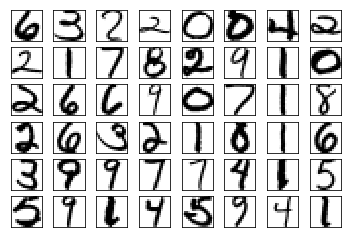

In [217]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(trainx[26 * i].reshape(16, 16), cmap='gray_r')

Les données USPS contiennent une variété d'écritures manuscrites. Afin d'en avoir une idée, nous en avons afficher ci-dessus quelques unes.

Lorsque nous faisions les TMEs, nous nous sommes acharnés à vouloir afficher les données USPS en $2$ dimensions, mais cela nous était impossible vu le nombre de dimensions et la manière dont nous procédions (sans réduction des dimensions). 

Nous avons par la suite découvert le **manifold learning**, qui, par ces multiples estimateurs non supervisés, projette des données de très hautes dimensions en de faibles dimensions. Ainsi, nous avons pu visualiser les données USPS en $2$ dimensions.

Ici, pour la vitesse d'exécution, nous utiliserons $1/4$ des données, ce qui fait environ $1820$ points.

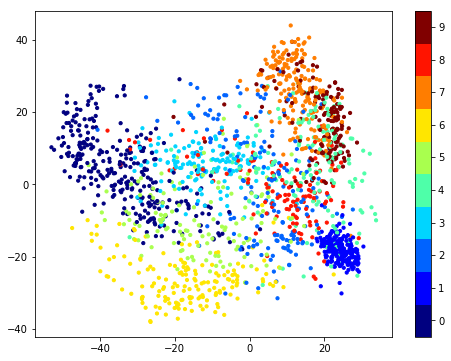

In [218]:
# Seulement le 1/4 des données
data = trainx[::4]
labels = trainy[::4]

# Projection des données en 2 dimensions
model = Isomap(n_components=2)
proj = model.fit_transform(data)

# Affichage
plt.figure(figsize=(8,6))
plt.scatter(proj[:, 0], proj[:, 1], s=10, c=labels, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)


Cette figure nous permet de comprendre comment sont reliées les données. Par exemple, nous pouvons en déduire que les chiffres $6$ et $1$ n'ont la plupart du temps pas beaucoup de pixels en commun, pour le chiffre $1$ d'ailleurs, les différentes écritures manuscrites se ressemblent beaucoup vu le petit groupement de points qui le répresente.

Avec la masse de points, nous avons néamoins un peu de difficultés de visualiser les données, c'est pourquoi ci-dessous, nous avons zoomé un peu plus sur chaque chiffre avant d'observer les différentes écritures manuscrites pour chacun d'eux.

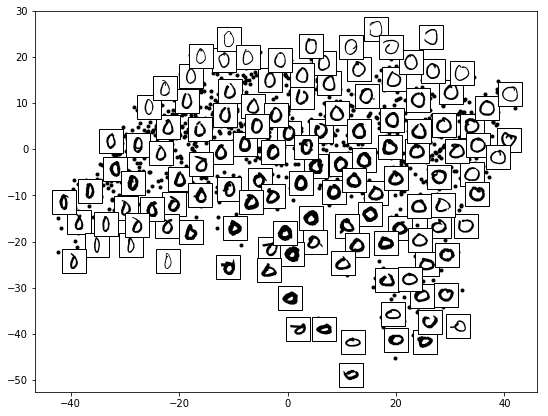

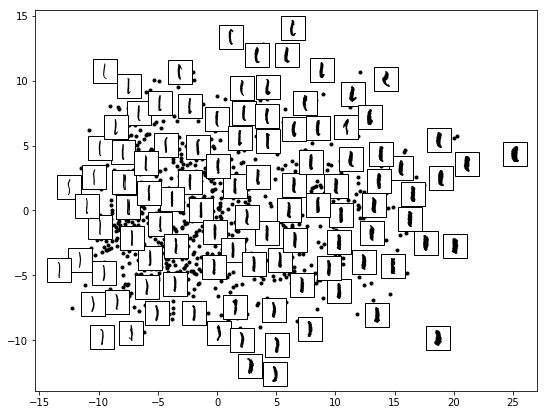

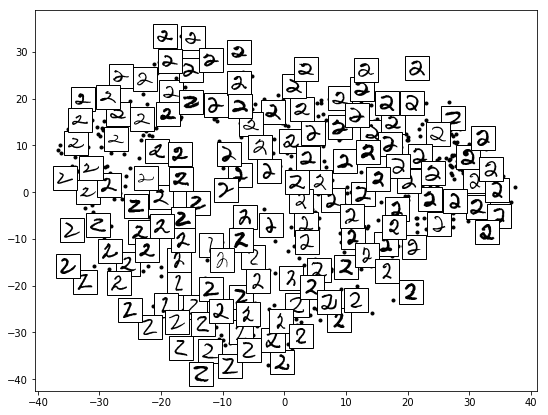

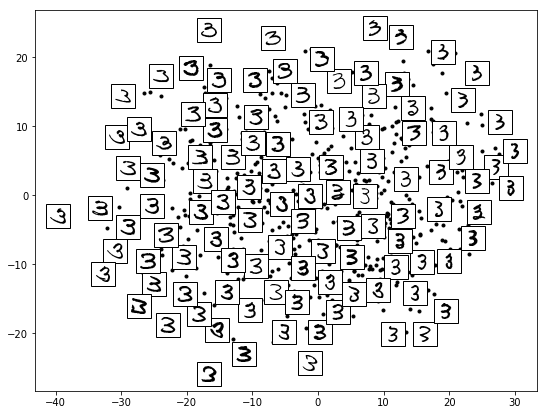

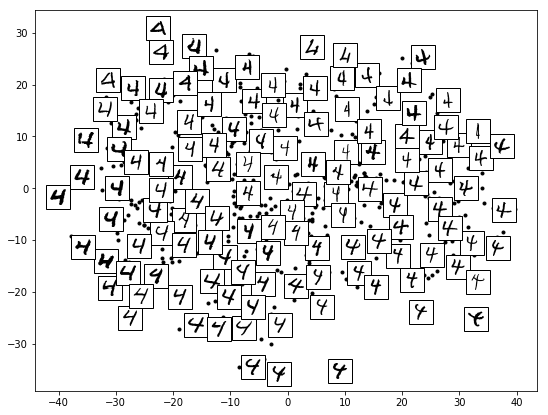

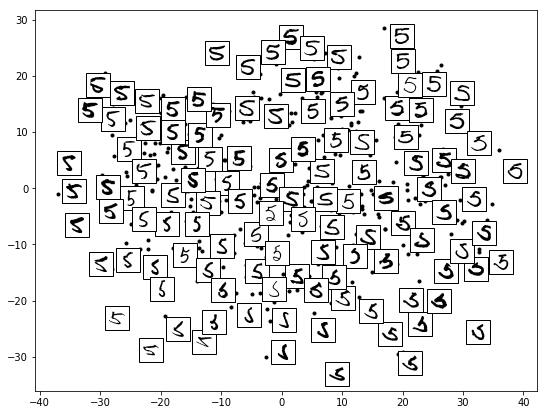

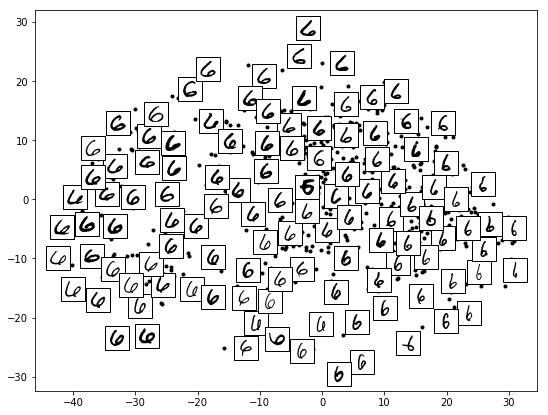

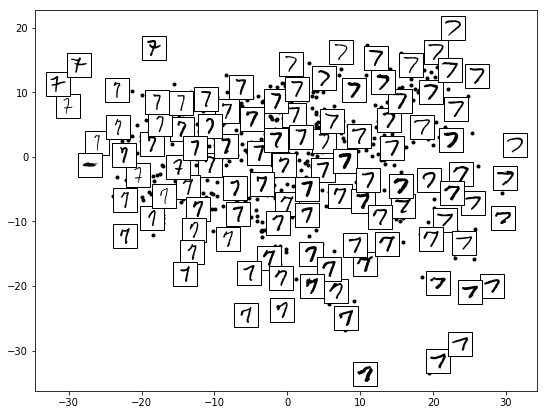

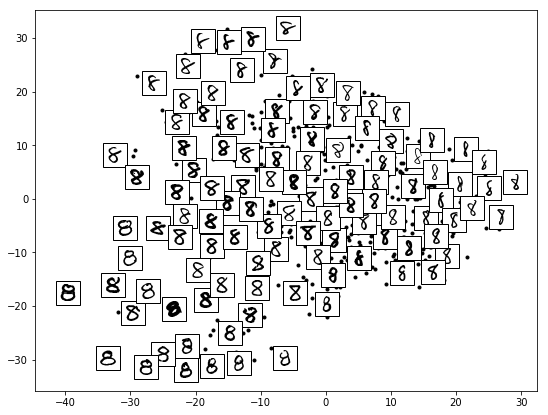

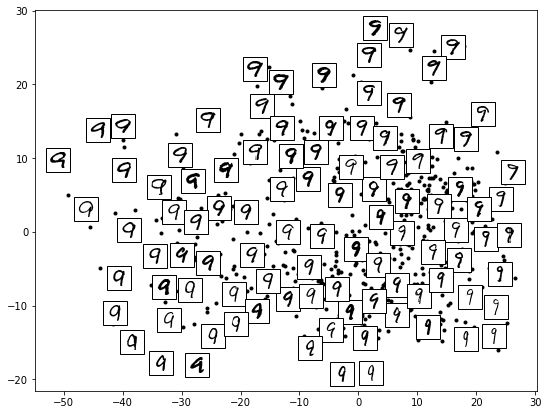

In [219]:
# Afficher en zoom les différences manuscrites pour chaque chiffre

for number in range(10):
    # Extraction du nombre number
    data = extract_one_number(number, trainx, trainy)
    
    # Affichage des différentes écritures manuscrites de ce nombre 
    fig, ax = plt.subplots(figsize=(9, 7))
    model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
    plot_components(data, model, images=data.reshape((-1, 16, 16)),
                    ax=ax, thumb_frac=0.05, cmap='gray_r')

Ainsi, nous remarquons que pour certains chiffres comme $1$, $0$, la principale différence réside d'une part en l'orientation, si *italique* ou non et d'autre part en se déplaçant d'un côté à l'autre de la figure, nous traversons les différentes mises en forme, du plus gras au moins. Aussi, certains chiffres se retrouvent isolés de leurs voisins, ces derniers sont pour la majorité des cas, des écritures manuscrites qui n'ont pas beaucoup de ressemblance avec le chiffre en question (vilaines écritures). Des $7$ qui ressemblent plus à des $1$ ou des $5$ qui ressemblent à des $s$, etc...

Ceci, en soi-même n'est pas très important pour la classification que nous réaliserons un peu plus loin, mais nous aide à comprendre les données, en l'occurrence les principales différences entre les chiffres, comment sont ils reliés, quels sont ceux qui se ressemblent, et plus en profondeur, quels sont ceux arborant moins de différence entre les écritures manuscrites et ceux avec plus de différence. 

In [220]:
def score(testy, testy_predict):
    """ Return le score étant donné les labels initiaux et les labels prédits """
    
    return np.mean((np.sign(testy_predict) == testy[:, np.newaxis]))

In [221]:
class1, class2 = 6, 9
trainx, trainy = extract_usps(train_file, class1, class2)
testx, testy = extract_usps(test_file, class1, class2)

In [222]:
linearReg_clf = LinearRegression(n_jobs=-1)

linearReg_clf.fit(trainx, trainy)

print("Regression linéaire \n===================\n")
print("Ensemble de paramètres :")
print("======================")
print(linearReg_clf.get_params())

testy_predict = linearReg_clf.predict(testx)

print("\nScore de bonne classification :")
print("=============================")
print("{:.2%}".format(score(testy, testy_predict)))

Regression linéaire 

Ensemble de paramètres :
{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'normalize': False}

Score de bonne classification :
50.03%


Regression Ridge 

Ensemble de paramètres parmis lesquels recherchés :
{'alphas': (0.01, 0.1, 1, 10, 100, 1000), 'class_weight': None, 'cv': None, 'fit_intercept': True, 'normalize': False, 'scoring': None}

Alpha sélectionné :
100.0

Score de bonne classification :
99.71%


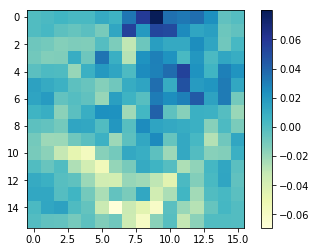

In [223]:
ridge_clf = RidgeClassifierCV(alphas=(0.01, 0.1, 1, 10, 100, 1000))

ridge_clf.fit(trainx, trainy)

print("Regression Ridge \n================\n")
print("Ensemble de paramètres parmis lesquels recherchés :")
print("==================================================")
print(ridge_clf.get_params())

print("\nAlpha sélectionné :")
print("===================")
print(ridge_clf.alpha_)

print("\nScore de bonne classification :")
print("=============================")
print("{:.2%}".format(ridge_clf.score(testx, testy)))

# Affichage de la matrice de poids
show_usps(ridge_clf.coef_)

Regression Lasso 

Ensemble de paramètres parmis lesquels recherchés :
{'alphas': (0.01, 0.1, 1, 10, 100, 1000), 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': 1, 'normalize': False, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}

Alpha sélectionné :
0.01

Score de bonne classification :
92.30%


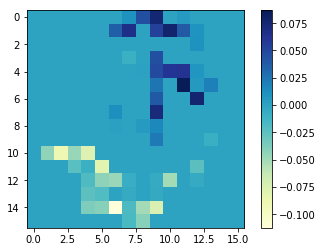

In [224]:
lasso_clf = LassoCV(alphas=(0.01, 0.1, 1, 10, 100, 1000))
lasso_clf.fit(trainx, trainy)

print("Regression Lasso \n================\n")
print("Ensemble de paramètres parmis lesquels recherchés :")
print("==================================================")
print(lasso_clf.get_params())

print("\nAlpha sélectionné :")
print("===================")
print(lasso_clf.alpha_)

print("\nScore de bonne classification :")
print("=============================")
print("{:.2%}".format(lasso_clf.score(testx, testy)))

# Affichage de la matrice de poids
show_usps(lasso_clf.coef_)

## LASSO et Inpainting

In [225]:
im = read_im("Images/papillon.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


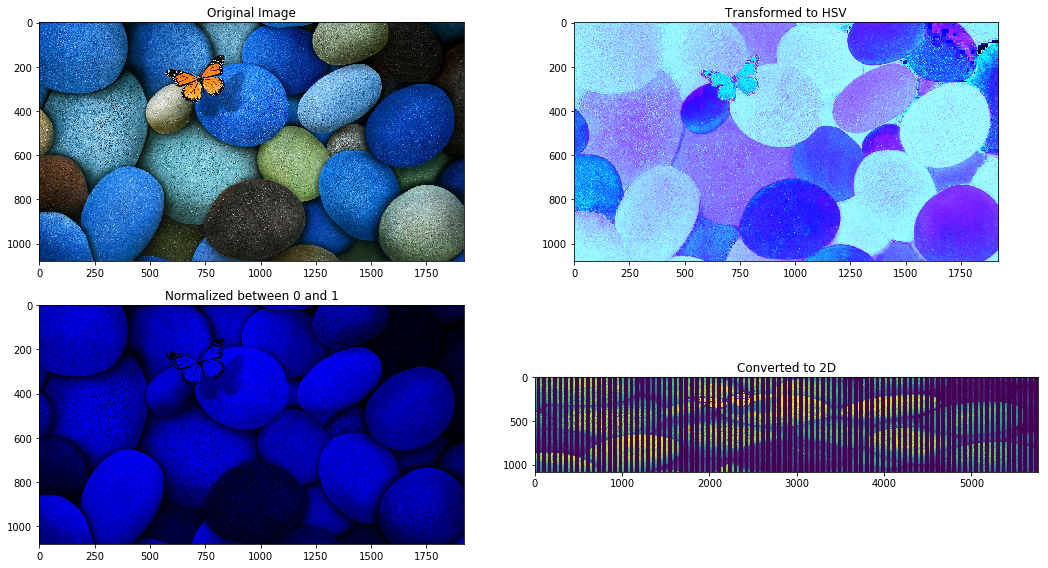

In [226]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

show_im(im, "Original Image", ax1[0])

im_hsv = rgb_to_hsv(im[:,:,:3])
show_im(im_hsv, "Transformed to HSV", ax1[1])

im_norm = normalize(im_hsv, 0, 1)
show_im(im_norm, "Normalized between 0 and 1", ax2[0])

im_norm_2D = transform_to_2D(im_norm)
show_im(im_norm_2D, "Converted to 2D", ax2[1])

fig.tight_layout()

In [227]:
print("Original Image\n"
      "===============\n", im[0])

print("\nTransformed to HSV\n"
      "==================\n", im_hsv[0])

print("\nNormalized between 0 and 1\n"
      "==========================\n", im_norm[0])

print("\nConverted to 2D\n"
      "===============\n", im_norm_2D[0])

Original Image
 [[ 84 158 221]
 [ 31 104 173]
 [  3  74 154]
 ...
 [  0  45  65]
 [  0  46  66]
 [  1  48  68]]

Transformed to HSV
 [[  0.57664233   0.6199095  221.        ]
 [  0.5809859    0.82080925 173.        ]
 [  0.5883002    0.9805195  154.        ]
 ...
 [  0.55128205   1.          65.        ]
 [  0.55050504   1.          66.        ]
 [  0.5497512    0.9852941   68.        ]]

Normalized between 0 and 1
 [[0.00226134 0.00243102 0.8666667 ]
 [0.00227838 0.00321886 0.6784314 ]
 [0.00230706 0.00384517 0.6039216 ]
 ...
 [0.00216189 0.00392157 0.25490198]
 [0.00215884 0.00392157 0.25882354]
 [0.00215589 0.0038639  0.26666668]]

Converted to 2D
 [0.00226134 0.00243102 0.8666667  ... 0.00215589 0.0038639  0.26666668]


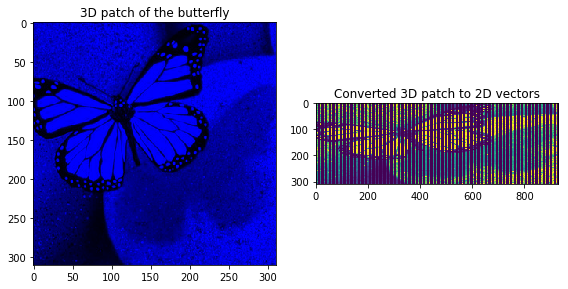

In [228]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 7))

patch = get_patch(300, 770, 310, im_norm)
show_im(patch, "3D patch of the butterfly", ax1)

patch_2D = transform_to_2D(patch)
show_im(patch_2D, "Converted 3D patch to 2D vectors", ax2)

fig.tight_layout()

100%|██████████| 103680/103680 [00:01<00:00, 66475.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


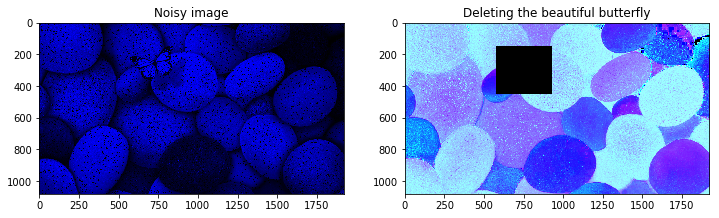

In [229]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

im_noise = noise(im_norm, 5)
show_im(im_noise, "Noisy image", ax1)

im_del = delete_rect(im_hsv, 300, 750, 300, 350)

show_im(im_del, "Deleting the beautiful butterfly", ax2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

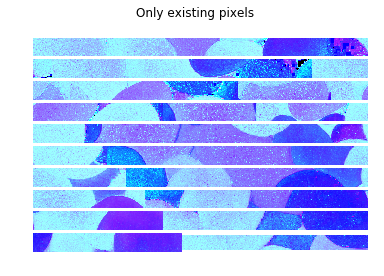

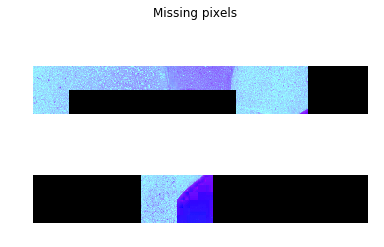

In [230]:
live, missing = image_patches(im_del, step=100)

# Plot patches with no missing pixels
plot_dico_patches(live, title="Only existing pixels", ncols=18)

# Plot patches with missing pixels
plot_dico_patches(missing, title="Missing pixels", ncols=7)

In [231]:
importlib.reload(utils)
importlib.reload(appendix_figures)
from utils import *
from appendix_figures import *

In [232]:
class inpaint:
    
    def __init__(self, im_del, step_patch=100, alpha=0.1):
        self.alpha = alpha
        self.step_patch = step_patch
        self.im_to_reconstruct = im_del.copy()
        live_patches, self.missing_patches = image_patches(im_del, step=step_patch)
        self.live_patches = np.array([np.array([np.array(line) for line in patch]) 
                                      for patch in live_patches])
        self.lasso = {}
        for i in "hsv":
            self.lasso[i] = Lasso(alpha=self.alpha)
        

    def fit(self, patch):
        
        X, Y = {i:[] for i in "hsv"}, {i:[] for i in "hsv"}
        for l in range(self.step_patch):
            for c in range(self.step_patch):                    
                if -100 not in patch[l, c]:
                    for i, canal in zip("hsv", range(3)):
                        X[i].append(self.live_patches[:][l][c, canal].flatten())
                        Y[i].append(patch[l, c, 0])
        
        for i in "hsv":
            self.lasso[i].fit(X[i], Y[i])                        
        
    def predict(self):
        self.reconstructed_patches = self.missing_patches.copy()
        for (i, j) in list(self.missing_patches.keys()):
            patch = self.missing_patches[i, j]
            for l in range(self.step_patch):
                for c in range(self.step_patch):
                    if -100 in patch[l, c]:
                        self.fit(patch)
                        y = []
                        for cl, cn in zip("hsv", range(3)):
                            pixels = [self.live_patches[:][l][c, cn].flatten()]
                            y.append(self.lasso[cl].predict(pixels))
                         
                        print(np.array(y))
                        self.reconstructed_patches[i, j][l, c] = np.array(y).ravel()
        return self.reconstructed_patches
    
    def fill(self):
        for (i, j) in list(self.reconstructed_patches.keys()):
            x, y = i - int(self.step_patch/2), j - int(self.step_patch/2)
            self.im_to_reconstruct[x:x+self.step_patch, y:y+self.step_patch] = np.array(self.reconstructed_patches[i, j])
        
        return self.im_to_reconstruct
        
        """
        X.append(self.live_patches[:][l][c].flatten())
                        Y.append(patch[l, c])

        self.lasso_clf.fit(X, Y)
        """

In [233]:
paint = inpaint(im_del, alpha=0.1)
#paint.fit()
reconstructed_patches = paint.predict()
reconstructed_img = paint.fill()

# Plot patches with missing pixels
plot_dico_patches(reconstructed_patches, title="Missing pixels", ncols=7)

plt.figure()
show_im(reconstructed_img)

[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.5909846

[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.5909846

[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.5909846

[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.5909846

[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.5909846

[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.5909846

[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.59098468]
 [0.59098468]
 [0.59098468]]
[[0.5909846

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.58730061]
 [0.58730061]
 [0.58730061]]
[[0.5873006

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.57459451]
 [0.57459451]
 [0.57459451]]
[[0.5745945

[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]


[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]


[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]


[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]


[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]


[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]


[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]


[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]


[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]


[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]


[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]
[[0.5558949]
 [0.5558949]
 [0.5558949]]


[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.5558949

[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.55589491]
 [0.55589491]
 [0.55589491]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.5905060

[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.5905060

[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.5905060

[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.5905060

[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.5905060

[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.5905060

[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.59050606]
 [0.59050606]
 [0.59050606]]
[[0.5905060

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.58801224]
 [0.58801224]
 [0.58801224]]
[[0.5880122

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.